# 1. Importing Libraries

Just importing important libraries

In [1]:
# Important libraries
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Loading in important data properties

### 2.1 Basic File Properties

Make sure to save the entire raw data in 'Data Extration'.
There should be four files: MM_S1_raw.csv, MT_S1_raw.csv, MT_S2_raw.csv, MT_S3_raw.csv, 

In [2]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = r"..\\..\\Data Extraction\\Old\\"+monkey+"_raw.csv"

# 3. Functional Decoders

### 3.1 Implementing the Functional Decoder Function

Get the activity matrix and kinematic data from the files

In [3]:
data_df = pd.read_csv(datafile_path)
headers = data_df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)

# Getting the train activity and kinematic matrix
activity_matrix = data_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
kinem_matrix = data_df.loc[:, 'x_acceleration':'y_acceleration']

# Transpose data to ensure that dimensions are correct for decoder values
tranposed_activity_matrix = activity_matrix.transpose()
tranposed_kinem_matrix = kinem_matrix.transpose()

A = tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
Y = tranposed_kinem_matrix.to_numpy()    # n_kinematics x n_timepoints


# 4. Building the Minimal Learning Effort Nengo Model

### 4.1 Setting up and Adjusting Model Parameters

In [4]:
# Getting the input and output data for the model
spikes = A
scaler = np.max(Y)
kin_data = Y / scaler

# Model information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Parameters to change
n_ensemble_neurons = 5000
ensemble_radius = 2
ensemble_synapse = 0.025
probe_synapse = 0.01

running_time = 450 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning

### 4.2 Implementing the Nengo Model

The image below is a visualization of the MELM model
![Architecture](MELM_architecture.png)

In [5]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:

    # Input signal
    input_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])

    # # Connect input spikes to another node with a synapse of 0.05
    # input_node_lowpassed = nengo.Node(size_in=n_neurons)
    # input_conn = Connection(input_node, input_node_lowpassed, synapse = 0.05)

    # Connect low-passed input to the first ensemble (neuron representation)
    representation_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=n_neurons, radius = ensemble_radius)
    nengo.Connection(input_node, representation_ensemble, synapse=ensemble_synapse)

    # Secondary representation branc with recurrent connection
    representation_ensemble_recc = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=n_neurons, radius = ensemble_radius)
    nengo.Connection(input_node, representation_ensemble_recc, synapse=ensemble_synapse)
    rep_recur_con = nengo.Connection(representation_ensemble_recc, representation_ensemble_recc, synapse=ensemble_synapse)

    # Connect first ensemble to output ensemble
    output_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=2, radius = ensemble_radius)
    learn_conn1 = nengo.Connection(representation_ensemble, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))
    learn_conn2 = nengo.Connection(representation_ensemble_recc, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))

    # Connect output to error
    error_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=2, radius = ensemble_radius)
    nengo.Connection(output_ensemble, error_ensemble)

    # Connect error to the learning connection
    nengo.Connection(error_ensemble, learn_conn1.learning_rule)
    nengo.Connection(error_ensemble, learn_conn2.learning_rule)

    # Get ground truth value
    truth_node = nengo.Node(lambda t: kin_data[:,int(t/dt) -1])
    nengo.Connection(truth_node, error_ensemble, transform=-1)

    # Probe for graphing
    p_post = nengo.Probe(output_ensemble, synapse=probe_synapse)

    # Stop learning after 80% of the running time has passed
    stop_learning = nengo.Node(output=lambda t: t >= training_time)
    nengo.Connection(
        stop_learning, error_ensemble.neurons, transform=-20 * np.ones((error_ensemble.n_neurons, 1))
    )

### 4.3 Running the Model and Plotting the Output

Build finished in 0:00:30.                                                      
Simulation finished in 0:15:19.                                                 


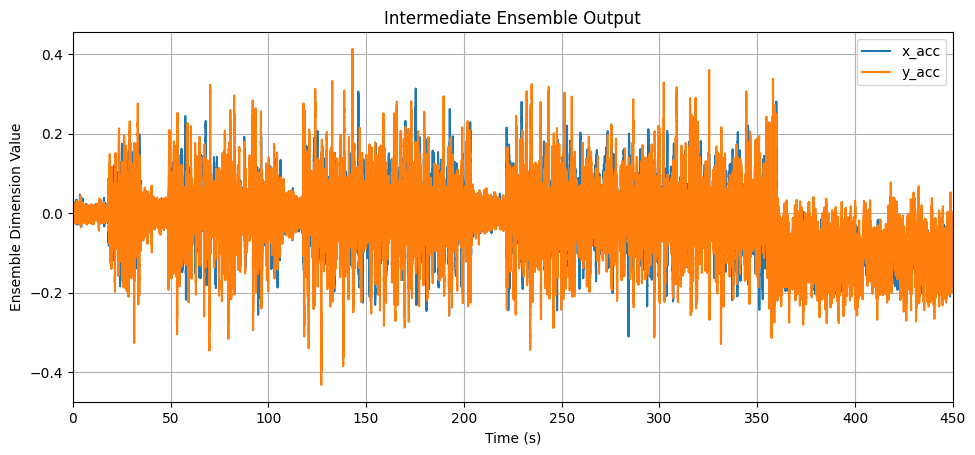

In [6]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

# 5. Plotting and Comparing the Outputs

### 5.2 Acceleration Comparisons

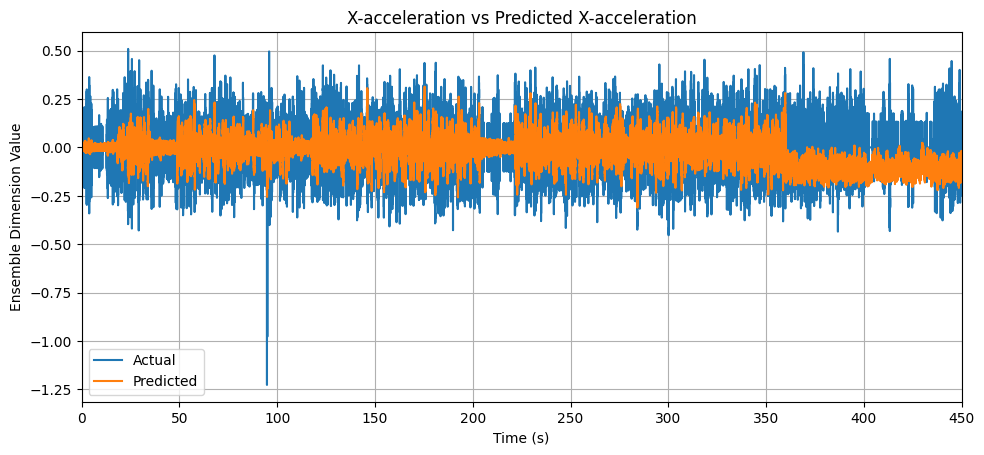

In [7]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), kin_data[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_post][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

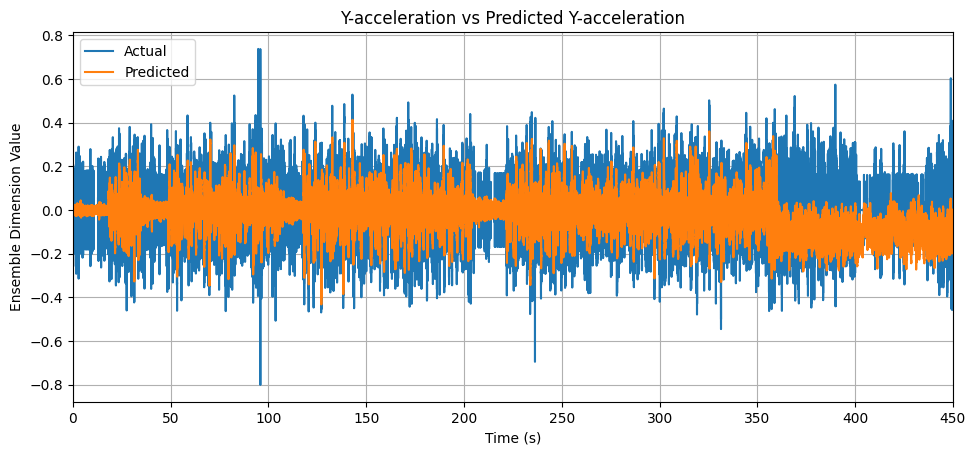

In [8]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), kin_data[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_post][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

# 6. Evautating Effectiveness of the Model

### 6.1 Implementing the Error Functions

In [9]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

### 6.2 Calculating Errors

In [10]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(kin_data[0, 0:len(sim.trange())], sim.data[p_post][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(kin_data[1, 0:len(sim.trange())], sim.data[p_post][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.07013605594537456
Root Mean_Squared Error: 0.0951265484142183

Y-Acceleration Error
Mean Absolute Error: 0.07961473545266909
Root Mean_Squared Error: 0.107019230881311



# Plotting Velocities

In [11]:
# Get the truth acceleration and the predicted acceleration from the moel
true_accels = kin_data[:, 0:len(sim.trange())]
pred_accels = [ sim.data[p_post][:, 0], sim.data[p_post][:, 1] ]

# Scale the accelerations by the normalization constant to provide true units
true_accels = np.array(true_accels) * scaler
pred_accels = np.array(pred_accels) * scaler

Since acceleration is the derivative of the velocity, we can integrate the acceleration (or sum the acceleration) to find the instantaneous velocities at time t.

In [12]:
# Get the truth velocities from the truth acceleration
true_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += true_accels[i][j] * dt
        vel.append(velsum)

    true_vels.append(vel)

# Get the predicted velocities from the predicted acceleration
pred_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += pred_accels[i][j] * dt
        vel.append(velsum)

    pred_vels.append(vel)

### Comparing Predicted and Actual Velocities

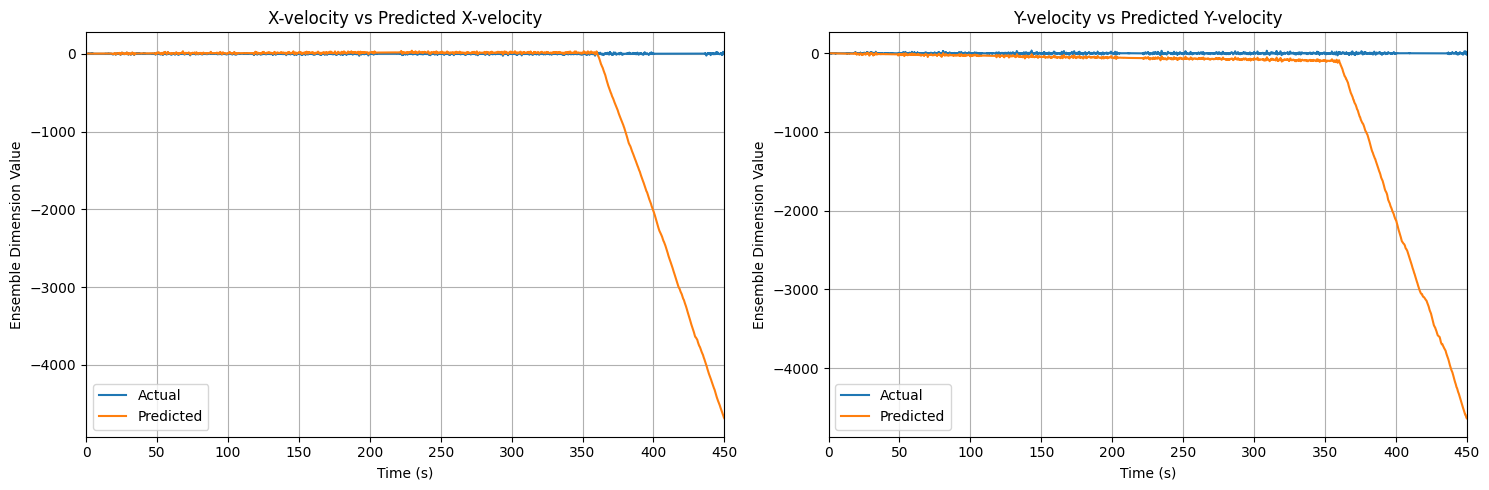

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), pred_vels[0])
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), pred_vels[1])
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

## Detrending the linear drifts

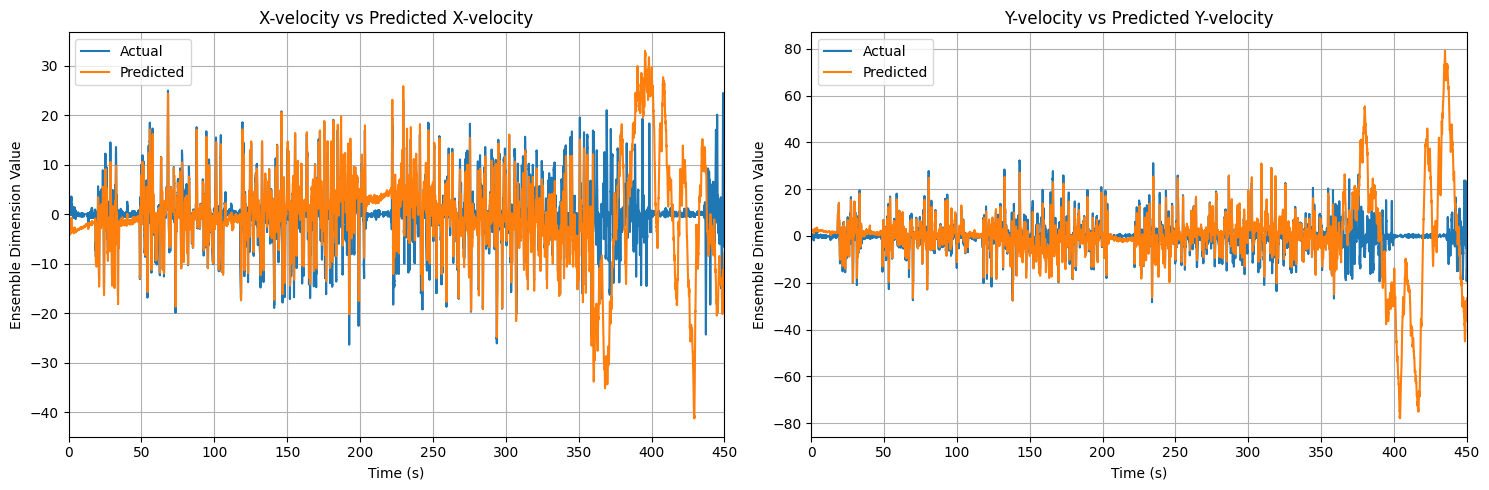

In [15]:
from scipy.signal import detrend

t_trainingstop = int(len(sim.trange())*0.8)-1
x_seg1 = detrend(pred_vels[0][:t_trainingstop])
x_seg2 = detrend(pred_vels[0][t_trainingstop:])
x_full = np.concatenate((x_seg1, x_seg2))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), x_full)
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()


y_seg1 = detrend(pred_vels[1][:t_trainingstop])
y_seg2 = detrend(pred_vels[1][t_trainingstop:])
y_full = np.concatenate((y_seg1, y_seg2))

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), y_full)
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()
